In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygtc
    
import sys 
sys.path.insert(0, '../src/')
import jsm_SHMR
import jsm_mcmc

import warnings; warnings.simplefilter('ignore')
import emcee
from multiprocess import Pool
import time

In [ ]:
# class Hammer:

#     def __init__(self, **kwargs):
#         for key, value in kwargs.items():
#             setattr(self, key, value)


#     def write_init(self):
#         with open(self.savedir+"chain_info.txt", 'w') as file: 
            
#             write = ['This run was measured against data with truth values of '+str(self.data.truths)+'\n', 
#             'It was initialized at '+str(self.theta_guess)+'\n', 
#             'Only '+str(self.ndim - self.nfixed)+' parameters are allowed to vary'+'\n'
#             'The chain has '+str(self.samples.shape[1])+' walkers and '+str(self.samples.shape[0])+' steps\n', 
#             'It was initialized with a_stretch = '+str(self.a_stretch)+'\n']
#             file.writelines("% s\n" % line for line in write) 
#             file.close()

#     def run(self, lnprob):
#         backend = emcee.backends.HDFBackend(self.savefile)
#         backend.reset(self.nwalkers, self.ndim)

#         p0 = [np.array(self.theta_guess) + 1e-2 * np.random.randn(self.ndim) for i in range(self.nwalkers)]
        
#         with Pool(self.ncores) as pool:
#             sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, lnprob, pool=pool, moves=emcee.moves.StretchMove(a=self.stretch, nf=self.nfixed), backend=backend)
#             start = time.time()
#             sampler.run_mcmc(p0, self.nsteps, progress="notebook")
#             end = time.time()
#             multi_time = end - start
#             print("Run took {0:.1f} hours".format(multi_time/3600))

#         self.sampler = sampler

#     def 

#         self.runtime = multi_time/3600
#         self.acceptance_frac = np.mean(sampler.acceptance_fraction)

#         try:
#             self.tau = sampler.get_autocorr_time()
#         except AutocorrError:
#             print("run a longer chain!")

#         self.last_samp = sampler.get_last_sample().coords
#         self.last_chisq = sampler.get_last_sample().log_prob*(-2)

#         values = []
#         for i in range(self.ndim):
#             post = np.percentile(self.last_samp[:, i], [16, 50, 84])
#             q = np.diff(post)
#             values.append([post[1], q[0], q[1]])
#         self.constraints = values

#         with open(self.savedir+"chain_info.txt", 'a') as file:
#             write1 = ['The mean acceptance fraction turned out to be '+str(self.acceptance_frac)+'\n',
#                       'The run took {0:.1f} hours'.format(self.runtime)+'\n',
#                       'The final step in the chain gives the following constraints\n']
#             write2 = []
#             for i,val in enumerate(self.constraints):
#                 write2.append(self.labels[i]+"="+str(val)+"\n")      

#             file.writelines("% s\n" % line for line in write1) 
#             file.writelines("% s\n" % line for line in write2) 
#             file.close()

        

### First the altered source code!

In [ ]:
def HAMMER(theta_0, lnprob, nwalkers, niter, ndim, ncores, stretch, nfixed, savefile):

    backend = emcee.backends.HDFBackend(savefile)
    backend.reset(nwalkers, ndim)

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool, moves=emcee.moves.StretchMove(a=stretch, nf=nfixed), backend=backend)
        start = time.time()
        sampler.run_mcmc(p0, niter, progress="notebook")
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} hours".format(multi_time/3600))

    return sampler

In [2]:
fid_theta = [2.1, 0.8, 10.5, 0, 0, 0]
start_theta = [1.8, 0.3, 10.5, -0.1, -0.01, 0]
priors = [[-1,7], [0,5], [10,11], [-3,2], [-2,2], [-2,2]]
params = ["$\\alpha$", "$\\sigma_0$", "$M_{*}$", "$\\delta$", "$\\beta$", "$\\gamma$"]
fixed = [False, False, True, True, True, True]

In [3]:
ndim = len(fid_theta)
nfixed = 0 # sum(fixed)
stretch = 2.0

nwalk = 100
nsteps = 1000
ncores = 8

min_mass = 6.5

In [4]:
print("reading in the data")

massdir = "/Users/jsmonzon/Research/data/MW-analog/meta_data_psi3/"

data = jsm_mcmc.init_data(fid_theta, "/Users/jsmonzon/Research/SatGen/mcmc/model_runs/src/mock_data.npy")
data.get_stats(min_mass=min_mass, plot=False)
data.get_data_points(plot=False)

reading in the data


In [ ]:
print("defining the forward model")

models = jsm_mcmc.load_models(massdir, read_red=True) # need to change this for every run!

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and\
        priors[1][0] < theta[1] < priors[1][1] and\
         priors[2][0] < theta[2] < priors[2][1] and\
          priors[3][0] < theta[3] < priors[3][1] and\
           priors[4][0] < theta[4] < priors[4][1] and\
            priors[5][0] < theta[5] < priors[5][1]:
        lp = 0.0
    else:
        lp = -np.inf
    return lp

def forward(theta):
    fixed_theta = np.where(fixed, fid_theta, theta).tolist()
    models.convert_zacc(fixed_theta, jsm_SHMR.redshift)
    models.get_stats(min_mass=min_mass)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)


In [ ]:
print("running the MCMC!")

mcmc_out = HAMMER(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim, ncores=ncores, stretch=stretch, nfixed=nfixed, savefile="../../mcmc/notebooks/test2.h5")


In [ ]:
reader = emcee.backends.HDFBackend("../../mcmc/notebooks/test.h5")

samples = reader.get_chain()

last_chisq = reader.get_last_sample().log_prob*(-2)

last_sample = reader.get_last_sample().coords


In [ ]:
if samples.shape[1] > 1000:
    a = 0.01
else:
    a = 0.1

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=a)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(params[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

----

----

----

### Now the altered intial conditions for the walkers

In [10]:
def HAMMER(p0, lnprob, nwalkers, niter, ndim, ncores, stretch, nfixed, savefile):

    backend = emcee.backends.HDFBackend(savefile)
    backend.reset(nwalkers, ndim)
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool, moves=emcee.moves.StretchMove(a=stretch, nf=nfixed), backend=backend)
        start = time.time()
        sampler.run_mcmc(p0, niter, progress="notebook", skip_initial_state_check=True)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} hours".format(multi_time/3600))

    return sampler

In [6]:
p0 = [np.array(start_theta) + 1e-2 * np.random.randn(ndim) for i in range(nwalk)]
p0_fixed = []

for i in range(nwalk):
    p0_fixed.append(np.where(fixed, fid_theta, p0[i]))

In [7]:
ndim = len(fid_theta)
nfixed = 0 # sum(fixed)
stretch = 2.0

nwalk = 100
nsteps = 300
ncores = 8

min_mass = 6.5

In [8]:
print("defining the forward model")

models = jsm_mcmc.load_models(massdir, read_red=True) # need to change this for every run!

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and\
        priors[1][0] < theta[1] < priors[1][1] and\
         priors[2][0] < theta[2] < priors[2][1] and\
          priors[3][0] < theta[3] < priors[3][1] and\
           priors[4][0] < theta[4] < priors[4][1] and\
            priors[5][0] < theta[5] < priors[5][1]:
        lp = 0.0
    else:
        lp = -np.inf
    return lp

def forward(theta): # no bullshit
    models.convert_zacc(theta, jsm_SHMR.redshift)
    models.get_stats(min_mass=min_mass)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)


defining the forward model


In [11]:
print("running the MCMC!")

mcmc_out = HAMMER(p0_fixed, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim, ncores=ncores, stretch=stretch, nfixed=nfixed, savefile="../../../data/chains/6p_initfix.h5")


running the MCMC!


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
reader = emcee.backends.HDFBackend("../../../data/chains/6p_initfix.h5")

samples = reader.get_chain()

last_chisq_1 = reader.get_last_sample().log_prob*(-2)

last_sample = reader.get_last_sample().coords

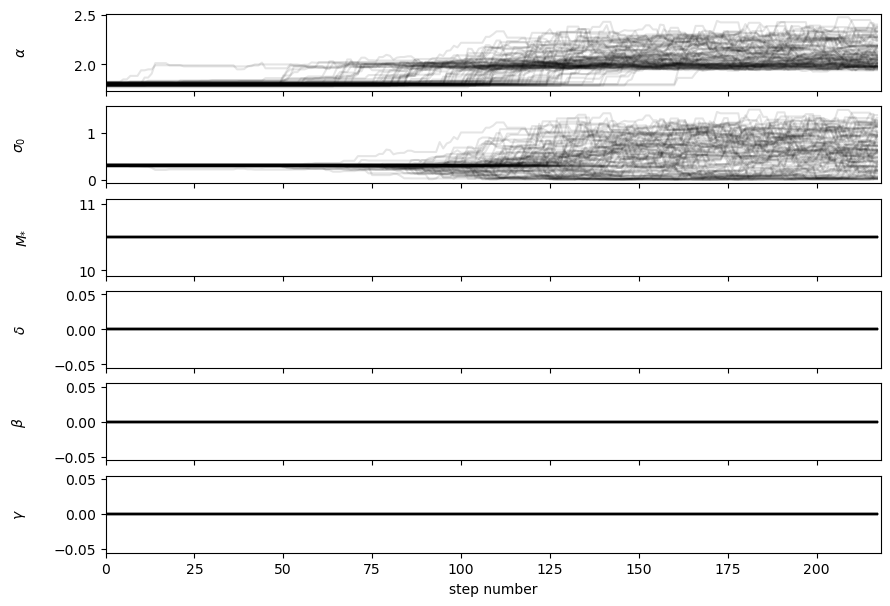

In [13]:
if samples.shape[1] > 1000:
    a = 0.01
else:
    a = 0.1

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=a)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(params[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

----

----

----

### Now the original

In [ ]:
ndim = 2
nfixed = 0

fid_theta = fid_theta[0:ndim]
priors = priors[0:ndim]
params = params[0:ndim]
start_theta = start_theta[0:ndim]

In [ ]:
models = jsm_mcmc.load_models(massdir, read_red=False) # need to change this for every run!

def forward(theta):
    models.convert(theta, jsm_SHMR.simple)
    models.get_stats(min_mass=min_mass)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and\
        priors[1][0] < theta[1] < priors[1][1]:
        lp = 0.0
    else:
        lp = -np.inf
    return lp

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

In [ ]:
    
print("running the MCMC!")

mcmc_out = HAMMER(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim, ncores=ncores, stretch=stretch, nfixed=nfixed, savefile="../../mcmc/notebooks/test1.h5")


In [ ]:
reader = emcee.backends.HDFBackend("../../mcmc/notebooks/test1.h5")

samples = reader.get_chain()

last_chisq_1 = reader.get_last_sample().log_prob*(-2)

last_sample = reader.get_last_sample().coords


In [ ]:
if samples.shape[1] > 1000:
    a = 0.01
else:
    a = 0.1

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=a)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(params[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [ ]:

fig, axs = plt.subplots(1, ndim, sharey=True, figsize=(14,8))
fig.tight_layout(pad=2.0)

for i in range(ndim):
    axs[i].scatter(last_sample[:,i], last_chisq, marker=".")
    axs[i].set_xlabel(params[i], fontsize=12)
    axs[i].axvline(data.truths[i], ls=":", color="black")
axs[0].set_ylabel("$\\chi^2$", fontsize=12)
plt.show()

In [ ]:
plt.scatter(last_chisq_1, last_chisq)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)